<a href="https://colab.research.google.com/github/NV2019/AERO_625_Platooning/blob/main/AP_CorrelatedNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Agent-Based Framework for Isolating Causal Pathways for Changes in Affective Polarization**

## **Scenario**

1. Exposure to upto 10 news sources over a period of 100 time-steps

2. ***Correlation*** between individual slant and news consumption

3. Only Left and Right inclined individuals constitute groups

4. No neutrals


In [1]:
%reset -f 
import numpy as np
import torch
import random
import time
device = 'cuda'

# Total Agent Population
Group_Size = 1000
Final_Time = 100

# LeftWing Extreme
LW_Extreme = 0.5
# RightWing Extreme
RW_Extreme = 0.5
# Neutral 
Neutral = 0.5

# In-Party Affect
# IPA Extreme
IPA_E_Min = 75
IPA_E_Max = 100
# IPA Moderate
IPA_M_Min = 50
IPA_M_Max = 100

# Out-Party Affect
# OPA Extreme
OPA_E_Min = 0
OPA_E_Max = 25
# OPA Moderate
OPA_M_Min = 25
OPA_M_Max = 50

# Neutral IPA and OPA
N_Min = 0
N_Max = 25

# News Outlets
News_Outlets = 100
NO_Min = 1
NO_Max = 10

# Slant
Slant_Min = 1
Slant_Max = 5

# Total Number of Simulation Runs
Monte_Carlo = 100

News_Index = torch.arange(1,News_Outlets+1,step=1)
# Time Series: 0: Update, 1: News Exposure, 2: In-degree, 3: Out-degree
TimeSeries_Values = torch.zeros((5,Group_Size,Final_Time),dtype=torch.double,device='cuda')
News_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
Difference_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
N_Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
Ones_Matrix = torch.ones((Group_Size,News_Outlets),device='cuda')
Ones_Vector = torch.ones((Group_Size),device='cuda')
NN_Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
PN_Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')

Agents = torch.zeros((Group_Size,10),dtype=torch.double,device='cuda')

# Partisan Orientations (Agents[0])
Agents[:,0] = torch.tensor([0,1,2],device='cuda')[torch.multinomial(torch.tensor([0.5,0.5,0.0]),Group_Size,replacement=True)]
# LeftWing Agent Population
LW_Agents = torch.where(Agents[:,0]==0)[0]
# RightWing Agent Population
RW_Agents = torch.where(Agents[:,0]==1)[0]
# Neutral Agent Population
N_Agents = torch.where(Agents[:,0]==2)[0]

# Slant
#LW_Extreme
pick = torch.tensor([True,False])[torch.multinomial(torch.tensor([LW_Extreme,1.0-LW_Extreme]),LW_Agents.size()[0],replacement=True)]
Agents[LW_Agents[pick==True],1] = 1
#LW_Moderates
Agents[LW_Agents[pick==False],1] = 2

#RW_Extreme
pick = torch.tensor([True,False])[torch.multinomial(torch.tensor([RW_Extreme,1.0-RW_Extreme]),RW_Agents.size()[0],replacement=True)]
Agents[RW_Agents[pick==True],1] = 5
#RW_Moderates
Agents[RW_Agents[pick==False],1] = 4

#Neutrals
pick = torch.where(Agents[:,1]==0)[0]
Agents[pick,1] = 3


# LW_Extremes or RW_Extremes
pick = torch.where(torch.logical_or(Agents[:,1]==1,Agents[:,1]==5)==1)[0]
# IPA 75-100
Agents[pick,2] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(IPA_E_Min,IPA_E_Max))
# OPA 0-25
Agents[pick,3] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(OPA_E_Min,OPA_E_Max))

# LW_Moderates or RW_Moderates
pick = torch.where(torch.logical_or(Agents[:,1]==2,Agents[:,1]==4)==1)[0]
# IPA, 50-100
Agents[pick,2] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(IPA_M_Min,IPA_M_Max))
# OPA 25-50
Agents[pick,3] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(OPA_M_Min,OPA_M_Max))

# Neutrals
pick = torch.where(Agents[:,1]==3)[0]
# IPA 0-25
Agents[pick,2] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(N_Min,N_Max))
# OPA 0 -25
Agents[pick,3] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(N_Min,N_Max))

News = torch.round(torch.cuda.DoubleTensor(News_Outlets).uniform_(Slant_Min,Slant_Max))

# News Slant -> Left, Neutral, Right
News_Left =  torch.round(torch.cuda.DoubleTensor(News_Outlets).uniform_(Slant_Min,3))
News_Right =  torch.round(torch.cuda.DoubleTensor(News_Outlets).uniform_(3,Slant_Max))

# Number of News Sources over the entire duration
Agents[:,5] = torch.round(torch.cuda.DoubleTensor(Group_Size).uniform_(NO_Min,NO_Max))

for t in range(1):
  #IPA
  TimeSeries_Values[0][:,t] = Agents[:,2].detach().clone()
  # OPA
  TimeSeries_Values[1][:,t] = Agents[:,3].detach().clone()
  # Agents Updating in the Current Iteration
  pick = torch.rand((Group_Size,),device='cuda')<=0.5
  Agents[:,4] = 0
  Agents[pick,4] = 1
  TimeSeries_Values[2][:,t] = Agents[:,4].detach().clone()
  TimeSeries_Values[3][:,t] = Agents[:,5].detach().clone()

  # Updating Agents with news sources left
  pick = torch.where(torch.logical_and(Agents[:,4]==1,Agents[:,5]>0))[0].int()

  News_Matrix = torch.zeros(Group_Size,News_Outlets,device='cuda',dtype=torch.double)
  for i in range(pick.size()[0]):
    News_Matrix[pick[i],torch.randint(NO_Min,News_Outlets,(1,))] = 1

  # Ensure correlation between Slant and news consumed
  News_Matrix[Agents[:,0]==0,:] = News_Left*News_Matrix[Agents[:,0]==0,:]
  News_Matrix[Agents[:,0]==1,:] = News_Right*News_Matrix[Agents[:,0]==1,:]

  # Difference
  Difference_Matrix = torch.zeros(Group_Size,News_Outlets,device='cuda',dtype=torch.double)
  Difference_Matrix[News_Matrix!=0] = torch.abs((Agents[:,1][:,None]*Ones_Matrix)[News_Matrix!=0]-News_Matrix[News_Matrix!=0])
  # Gains 
  Gains_Matrix = torch.zeros(Group_Size,News_Outlets,device='cuda',dtype=torch.double)
  Gain_Matrix[News_Matrix!=0] = -10*((torch.exp(2*(Difference_Matrix[News_Matrix!=0]-2*Ones_Matrix[News_Matrix!=0]))-Ones_Matrix[News_Matrix!=0])/(torch.exp(2*(Difference_Matrix[News_Matrix!=0]-2*Ones_Matrix[News_Matrix!=0]))+Ones_Matrix[News_Matrix!=0]))
  NN_Gain_Matrix = Gain_Matrix.detach().clone()
  NN_Gain_Matrix[Gain_Matrix>0] = 0
  PN_Gain_Matrix = Gain_Matrix.detach().clone()
  PN_Gain_Matrix[Gain_Matrix<0] = 0
  # Damping Factor
  # k = 0.1
  # l = 1000
  # Agents[:,6] = torch.ones(Group_Size,device='cuda',dtype=torch.double) - ((torch.ones(Group_Size,device='cuda',dtype=torch.double)-k*torch.exp(TimeSeries_Values[0][:,t]-50*torch.ones(Group_Size,device='cuda',dtype=torch.double)))/(torch.ones(Group_Size,device='cuda',dtype=torch.double)-l*torch.exp(100*torch.ones(Group_Size,device='cuda',dtype=torch.double)-50*torch.ones(Group_Size,device='cuda',dtype=torch.double)))) 
  #New_IPA 
  Agents[:,2] = TimeSeries_Values[0][:,t]+torch.sum(PN_Gain_Matrix,1)
  Agents[torch.where(Agents[:,2]>100)[0],2] = 100
  # # Damping Factor
  # Agents[:,6] = torch.ones(Group_Size,device='cuda',dtype=torch.double) - ((torch.ones(Group_Size,device='cuda',dtype=torch.double)-torch.exp(TimeSeries_Values[0][:,t]-0*torch.ones(Group_Size,device='cuda',dtype=torch.double)))/(torch.ones(Group_Size,device='cuda',dtype=torch.double)-torch.exp(50*torch.ones(Group_Size,device='cuda',dtype=torch.double)-0*torch.ones(Group_Size,device='cuda',dtype=torch.double)))) 
  #New_OPA 
  Agents[:,3] = TimeSeries_Values[1][:,t]+torch.sum(NN_Gain_Matrix,1)
  Agents[torch.where(Agents[:,3]<0)[0],3] = 0
  # Number of Exposure to News Content Left
  #if pick.size()[0]>0:
  Agents[pick.long(),5] = TimeSeries_Values[3][pick.long(),t] - 1


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


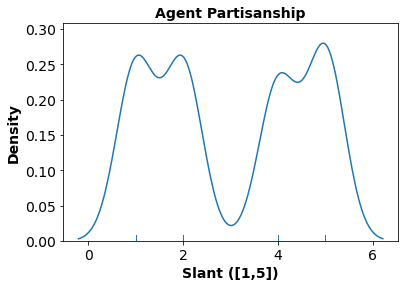

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import collections as matcoll
import seaborn as sns

# partisans = ['Left-Extreme','Left-Moderate','Right-Moderate','Right-Extreme']
target1 = torch.logical_or(Agents[:,1]==1,Agents[:,1]==2).cpu().numpy()
target2 = torch.logical_or(Agents[:,1]==4,Agents[:,1]==5).cpu().numpy()

sns.distplot(Agents[:,1].cpu().numpy(),hist=False,rug=True)
# sns.distplot(Agents[target1,1].cpu().numpy(),hist=False,rug=True)
# sns.distplot(Agents[target2,1].cpu().numpy(),hist=False,rug=True)

plt.title('Agent Partisanship', fontweight='bold',fontsize=14)
plt.xlabel('Slant ([1,5])', fontweight='bold',fontsize=14)
plt.ylabel('Density', fontweight='bold',fontsize=14)
# plt.legend([' ','Left Wing','Right Wing'])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams['font.family'] = 'sans-serif'

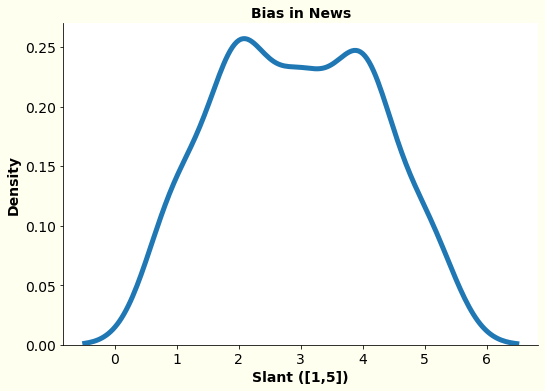

In [7]:
sns.displot(data=News.cpu().numpy(),kind="kde",height=5, aspect=1.5,linewidth=5)

plt.title('Bias in News', fontweight='bold',fontsize=14)
plt.xlabel('Slant ([1,5])', fontweight='bold',fontsize=14)
plt.ylabel('Density', fontweight='bold',fontsize=14)
# plt.legend(['Left Wing','Right Wing'])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams['font.family'] = 'sans-serif'


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/dis

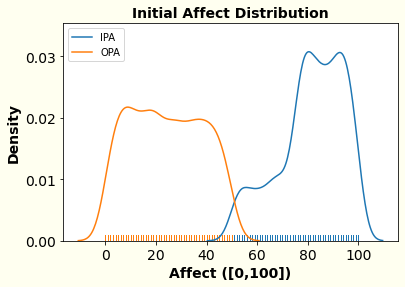

In [8]:
# partisans = ['Left-Extreme','Left-Moderate','Right-Moderate','Right-Extreme']
target1 = torch.logical_or(Agents[:,1]==1,Agents[:,1]==2).cpu().numpy()
target2 = torch.logical_or(Agents[:,1]==4,Agents[:,1]==5).cpu().numpy()

sns.distplot(TimeSeries_Values[0][TimeSeries_Values[0][:,0]>=50,0].cpu().numpy(),hist=False,rug=True)
sns.distplot(TimeSeries_Values[1][TimeSeries_Values[1][:,0]<=50,0].cpu().numpy(),hist=False,rug=True)

plt.title('Initial Affect Distribution', fontweight='bold',fontsize=14)
plt.xlabel('Affect ([0,100])', fontweight='bold',fontsize=14)
plt.ylabel('Density', fontweight='bold',fontsize=14)
plt.legend(['IPA','OPA'])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams['font.family'] = 'sans-serif'


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/dis

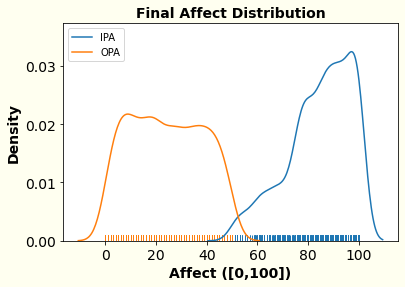

In [9]:
# partisans = ['Left-Extreme','Left-Moderate','Right-Moderate','Right-Extreme']
target1 = torch.logical_or(Agents[:,1]==1,Agents[:,1]==2).cpu().numpy()
target2 = torch.logical_or(Agents[:,1]==4,Agents[:,1]==5).cpu().numpy()

sns.distplot(Agents[Agents[:,2]>=50,2].cpu().numpy(),hist=False,rug=True)
sns.distplot(Agents[Agents[:,3]<=50,3].cpu().numpy(),hist=False,rug=True)

plt.title('Final Affect Distribution', fontweight='bold',fontsize=14)
plt.xlabel('Affect ([0,100])', fontweight='bold',fontsize=14)
plt.ylabel('Density', fontweight='bold',fontsize=14)
plt.legend(['IPA','OPA'])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams['font.family'] = 'sans-serif'
